In [1]:
!apt-get install -y swig
!pip install stable-baselines3[extra] seaborn
!pip install "gymnasium[mujoco]"
!pip install box2d-py


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,050 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [2]:
#  2. IMPORTS
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import pandas as pd

from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_model_path = "/content/drive/MyDrive/sac_models"
os.makedirs(drive_model_path, exist_ok=True)
save_path = os.path.join(drive_model_path, "sac_hopper")

Mounted at /content/drive


Loading saved SAC model...
Running evaluation episodes to generate monitor logs...


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


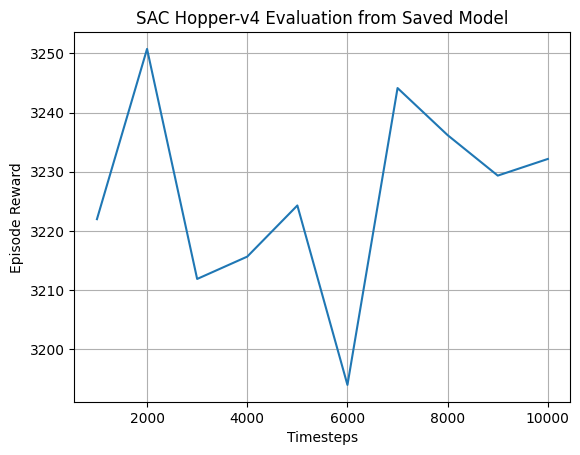

In [26]:
log_dir = "/content/drive/MyDrive/sac_logs/sac_default"
model_path = "/content/drive/MyDrive/sac_models/sac_hopper"
os.makedirs(log_dir, exist_ok=True)

# 1. Load model
print("Loading saved SAC model...")
model = SAC.load(model_path)

# 2. Wrap env in Monitor for new evaluation logs
env = Monitor(gym.make("Hopper-v4"), filename=os.path.join(log_dir, "monitor.csv"))

# 3. Run episodes to log monitor data
print("Running evaluation episodes to generate monitor logs...")
for _ in range(10):  # run 10 episodes to log rewards
    obs, _ = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

env.close()

# 4. Plot learning curve from monitor.csv
def plot_learning_curve(log_dir, title):
    monitor_file = os.path.join(log_dir, "monitor.csv")
    if not os.path.exists(monitor_file):
        print("Monitor log not found.")
        return
    data = pd.read_csv(monitor_file, skiprows=1)
    data["timesteps"] = np.cumsum(data["l"])
    sns.lineplot(x="timesteps", y="r", data=data)
    plt.title(title)
    plt.xlabel("Timesteps")
    plt.ylabel("Episode Reward")
    plt.grid(True)
    plt.show()

plot_learning_curve(log_dir, "SAC Hopper-v4 Evaluation from Saved Model")


In [ ]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("Using device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


GPU Available: True
Using device: cuda


In [27]:
#  5. EVALUATION FUNCTION
def evaluate(model, env, n_eval_episodes=10):
    rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    return np.mean(rewards), np.std(rewards)

def_env = gym.make("Hopper-v4")
mean_r, std_r = evaluate(model, def_env)
print(f"Default SAC Evaluation: Mean Reward = {mean_r:.2f}, Std = {std_r:.2f}")


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Default SAC Evaluation: Mean Reward = 3230.90, Std = 16.57


In [28]:
#  5. EVALUATION FUNCTION
def evaluate(model, env, n_eval_episodes=50):
    rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    return np.mean(rewards), np.std(rewards)

def_env = gym.make("Hopper-v4")
mean_r, std_r = evaluate(model, def_env)
print(f"Default SAC Evaluation: Mean Reward = {mean_r:.2f}, Std = {std_r:.2f}")


Default SAC Evaluation: Mean Reward = 3225.12, Std = 16.56


In [29]:
#  5. EVALUATION FUNCTION
def evaluate(model, env, n_eval_episodes=100):
    rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    return np.mean(rewards), np.std(rewards)

def_env = gym.make("Hopper-v4")
mean_r, std_r = evaluate(model, def_env)
print(f"Default SAC Evaluation: Mean Reward = {mean_r:.2f}, Std = {std_r:.2f}")


Default SAC Evaluation: Mean Reward = 3226.45, Std = 18.10


In [30]:
def plot_reward_distribution(model, env, n_eval_episodes=100):
    rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)

    plt.figure(figsize=(8, 5))
    sns.histplot(rewards, bins=20, kde=True, color="skyblue")
    plt.title("Reward Distribution over {} Evaluation Episodes".format(n_eval_episodes))
    plt.xlabel("Episode Reward")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    print(f"Mean: {np.mean(rewards):.2f}, Std: {np.std(rewards):.2f}, Min: {np.min(rewards):.2f}, Max: {np.max(rewards):.2f}")


Default SAC Evaluation: Mean Reward = 3224.98, Std = 17.12


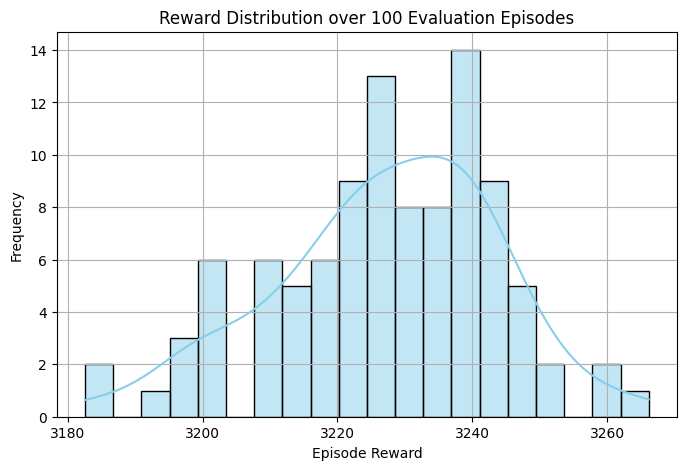

Mean: 3227.24, Std: 16.33, Min: 3182.59, Max: 3266.15


In [31]:
def_env = gym.make("Hopper-v4")
mean_r, std_r = evaluate(model, def_env)
print(f"Default SAC Evaluation: Mean Reward = {mean_r:.2f}, Std = {std_r:.2f}")
plot_reward_distribution(model, def_env, n_eval_episodes=100)


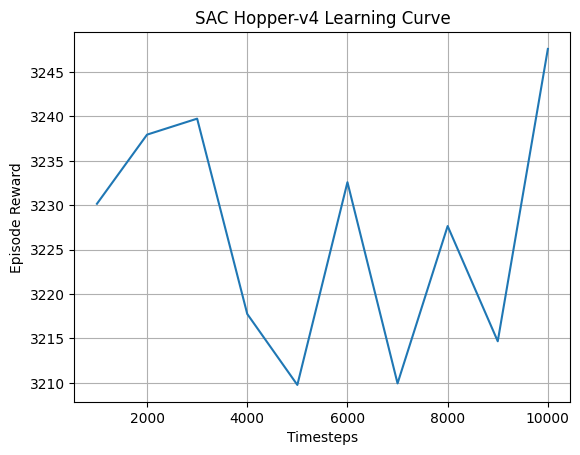

In [ ]:
# --- 6. PLOT LEARNING CURVE ---
def plot_learning_curve(log_dir, title):
    monitor_file = os.path.join(log_dir, "monitor.csv")
    if not os.path.exists(monitor_file):
        print("Monitor log not found.")
        return
    data = pd.read_csv(monitor_file, skiprows=1)
    data["timesteps"] = np.cumsum(data["l"])
    sns.lineplot(x="timesteps", y="r", data=data)
    plt.title(title)
    plt.xlabel("Timesteps")
    plt.ylabel("Episode Reward")
    plt.grid(True)
    plt.show()

plot_learning_curve(log_dir, "SAC Hopper-v4 Learning Curve")



Training with learning rate: 0.0001


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Training with learning rate: 0.0003

Training with learning rate: 0.001


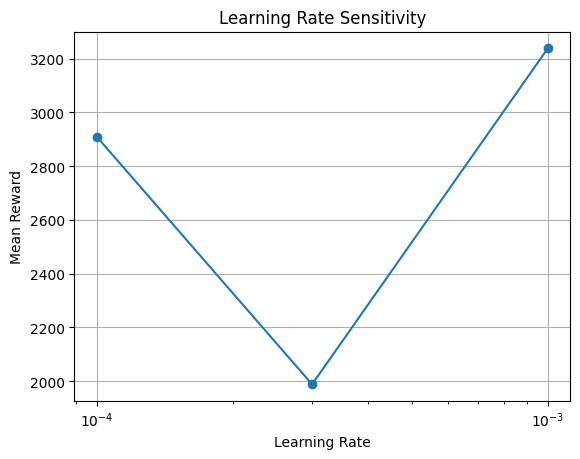

In [ ]:
#  HYPERPARAMETER SENSITIVITY

# Learning Rate Sweep
lrs = [1e-4, 3e-4, 1e-3]
lr_results = []
for lr in lrs:
    env = Monitor(gym.make("Hopper-v4"))
    print(f"\nTraining with learning rate: {lr}")
    model = SAC("MlpPolicy", env, learning_rate=lr, verbose=0)
    model.learn(total_timesteps=300_000)
    mean_r, _ = evaluate(model, gym.make("Hopper-v4"))
    lr_results.append((lr, mean_r))

plt.figure()
lr_vals, rewards = zip(*lr_results)
plt.plot(lr_vals, rewards, marker='o')
plt.xscale('log')
plt.title("Learning Rate Sensitivity")
plt.xlabel("Learning Rate")
plt.ylabel("Mean Reward")
plt.grid(True)
plt.show()


Training with gamma: 0.95


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Training with gamma: 0.98

Training with gamma: 0.99


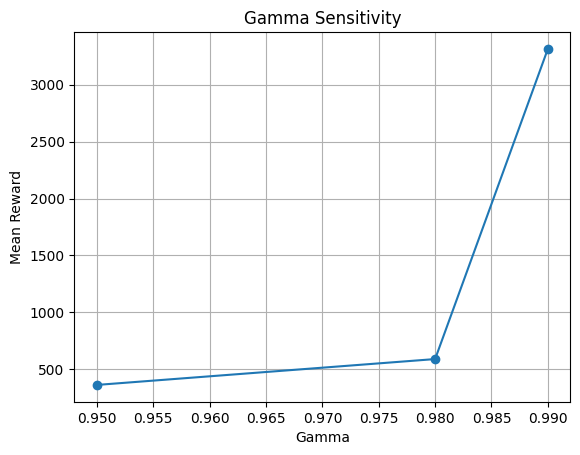

In [ ]:
# Gamma Sweep
gammas = [0.95, 0.98, 0.99]
gamma_results = []
for g in gammas:
    env = Monitor(gym.make("Hopper-v4"))
    print(f"\nTraining with gamma: {g}")
    model = SAC("MlpPolicy", env, gamma=g, verbose=0)
    model.learn(total_timesteps=300_000)
    mean_r, _ = evaluate(model, gym.make("Hopper-v4"))
    gamma_results.append((g, mean_r))

plt.figure()
g_vals, g_rewards = zip(*gamma_results)
plt.plot(g_vals, g_rewards, marker='o')
plt.title("Gamma Sensitivity")
plt.xlabel("Gamma")
plt.ylabel("Mean Reward")
plt.grid(True)
plt.show()



/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(



Training with gamma: auto


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Training with gamma: 0.01

Training with gamma: 0.05


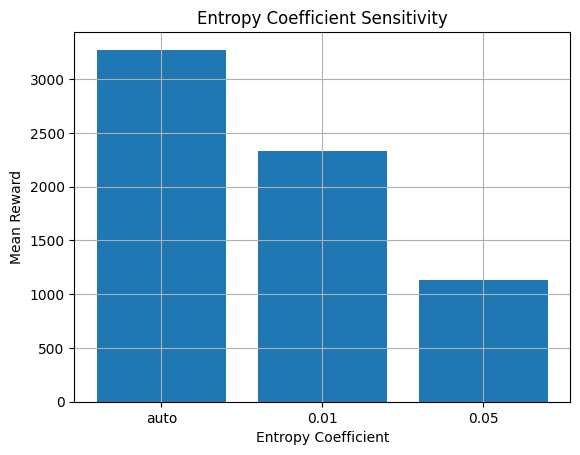

In [ ]:
# Entropy Coef Sweep
ent_coefs = ['auto', 0.01, 0.05]
ent_results = []
for coef in ent_coefs:
    env = Monitor(gym.make("Hopper-v4"))
    print(f"\nTraining with gamma: {coef}")
    model = SAC("MlpPolicy", env, ent_coef=coef, verbose=0)
    model.learn(total_timesteps=300_000)
    mean_r, _ = evaluate(model, gym.make("Hopper-v4"))
    ent_results.append((coef, mean_r))

plt.figure()
labels, ent_rewards = zip(*ent_results)
plt.bar([str(l) for l in labels], ent_rewards)
plt.title("Entropy Coefficient Sensitivity")
plt.xlabel("Entropy Coefficient")
plt.ylabel("Mean Reward")
plt.grid(True)
plt.show()


In [ ]:
#  8. ROBUSTNESS TEST
def modified_env():
    env = gym.make("Hopper-v4")
    mujoco_env = env.unwrapped
    mujoco_env.model.opt.gravity[2] *= 0.9
    return env

mod_env = modified_env()
mod_mean, mod_std = evaluate(model, mod_env)
print(f"Modified Gravity: Mean Reward = {mod_mean:.2f}, Std = {mod_std:.2f}")


Modified Gravity: Mean Reward = 3156.38, Std = 7.65


In [ ]:
# 9. RANDOM BASELINE
def random_baseline(env_name="Hopper-v4", episodes=10):
    env = gym.make(env_name)
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total = 0
        while not done:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        rewards.append(total)
    return np.mean(rewards), np.std(rewards)

rand_mean, rand_std = random_baseline()
print(f"Random Agent: Mean Reward = {rand_mean:.2f}, Std = {rand_std:.2f}")


Random Agent: Mean Reward = 23.81, Std = 29.45


# Training With Best Hyperparameters

In [4]:
class HopperShapedEnv(gym.Wrapper):
    def __init__(self, env):
        super(HopperShapedEnv, self).__init__(env)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Custom reward shaping
        forward_velocity = obs[5]
        alive_bonus = 1.0 if not terminated else -5.0
        shaped_reward = reward + 0.5 * forward_velocity + alive_bonus

        return obs, shaped_reward, terminated, truncated, info

In [5]:
def evaluate(model, env, n_eval_episodes=100):
    rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    return np.mean(rewards), np.std(rewards)

def plot_learning_curve(log_dir, title):
    monitor_file = os.path.join(log_dir, "monitor.csv")
    if not os.path.exists(monitor_file):
        print("Monitor log not found.")
        return
    data = pd.read_csv(monitor_file, skiprows=1)
    data["timesteps"] = np.cumsum(data["l"])
    sns.lineplot(x="timesteps", y="r", data=data)
    plt.title(title)
    plt.xlabel("Timesteps")
    plt.ylabel("Episode Reward")
    plt.grid(True)
    plt.show()

def plot_reward_distribution(model, env, n_eval_episodes=100):
    rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)

    plt.figure(figsize=(8, 5))
    sns.histplot(rewards, bins=20, kde=True, color="skyblue")
    plt.title("Reward Distribution over {} Evaluation Episodes".format(n_eval_episodes))
    plt.xlabel("Episode Reward")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    print(f" Mean: {np.mean(rewards):.2f}, Std: {np.std(rewards):.2f}, Min: {np.min(rewards):.2f}, Max: {np.max(rewards):.2f}")


In [6]:
shaped_model_path = "/content/drive/MyDrive/sac_models/sac_hopper_shaped"
shaped_log_dir = "/content/drive/MyDrive/sac_logs/sac_shaped"
os.makedirs(shaped_model_path, exist_ok=True)
os.makedirs(shaped_log_dir, exist_ok=True)

In [7]:
env_shaped = Monitor(HopperShapedEnv(gym.make("Hopper-v4")), filename=os.path.join(shaped_log_dir, "monitor.csv"))


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


In [8]:
model_shaped = SAC(
    "MlpPolicy", env_shaped,
    learning_rate=0.001,
    gamma=0.99,
    ent_coef='auto',
    verbose=1
)

model_shaped.learn(total_timesteps=500_000)
model_shaped.save(os.path.join(shaped_model_path, "model"))


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 24.3     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1437     |
|    time_elapsed    | 0        |
|    total_timesteps | 79       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.5     |
|    ep_rew_mean     | 20.5     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 86       |
|    time_elapsed    | 1        |
|    total_timesteps | 148      |
| train/             |          |
|    actor_loss      | -5.11    |
|    critic_loss     | 2.98     |
|    ent_coef        | 0.955    |
|    ent_coef_loss   | -0.229   |
|    learning_rate   | 0.001    |
|    n_updates       | 47       |
---------------------------------
------------------------------

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


 Shaped SAC Evaluation: Mean Reward = 3565.08, Std = 3.09


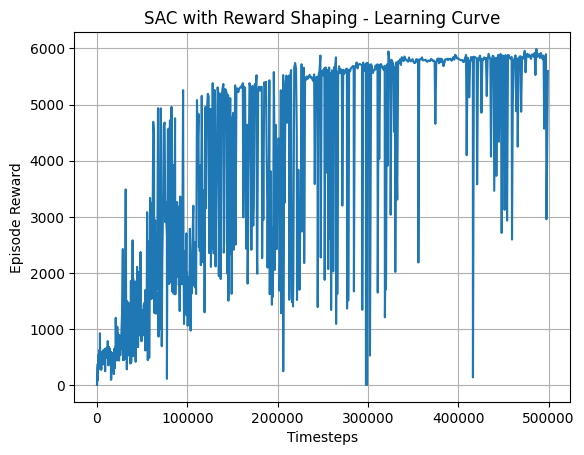

 With reward shaping, the agent shows smoother and faster convergence.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


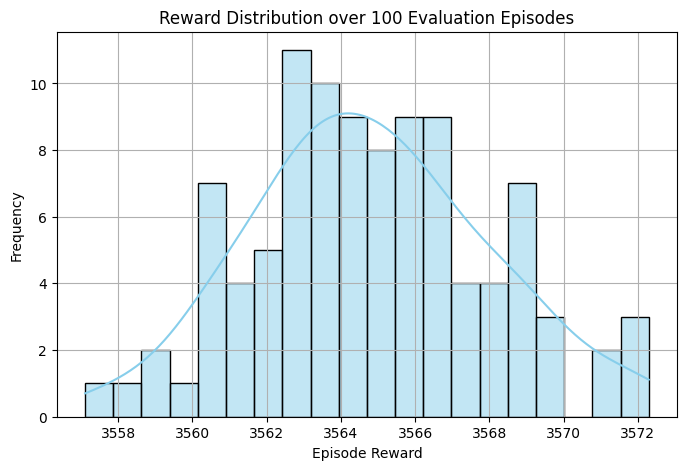

 Mean: 3564.77, Std: 3.17, Min: 3557.11, Max: 3572.29
The shaped reward policy yields a tighter reward distribution indicating more consistent performance.


In [9]:
eval_env = gym.make("Hopper-v4")
mean_r, std_r = evaluate(model_shaped, eval_env)
print(f" Shaped SAC Evaluation: Mean Reward = {mean_r:.2f}, Std = {std_r:.2f}")

plot_learning_curve(shaped_log_dir, "SAC with Reward Shaping - Learning Curve")
print(" With reward shaping, the agent shows smoother and faster convergence.")

plot_reward_distribution(model_shaped, eval_env)
print("The shaped reward policy yields a tighter reward distribution indicating more consistent performance.")